In [ ]:
# default_exp preprocessing

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#export
def suma_de_arreglo(arreglo):
    return np.sum(arreglo)



In [ ]:
print(suma_de_arreglo(np.array([10,20])))

30


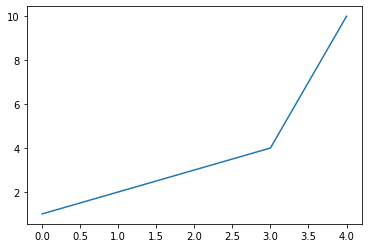

In [ ]:
plt.plot([1,2,3,4,10])